In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib as mpl
from astropy.table import Table
import astropy.units as u
import astropy.constants as c

import sys
sys.path.append('../../tools/')
from dust_extinction import calALambda
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)
color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [2]:
def mag1_mag2(X, Y, bin_size=1, flux=False):
    '''
    calculate the color using multi-band photometry
    
    Parameters
    ----------
    X, Y : array-like
        X-, Y-band photometry
        column 1 - obs time (day)
        column 2 - magnitude
        column 3 - (symmetric) uncertainty
        column 4 & 5 (optional) - (upper & lower) uncertainty
    bin_size : float, default = 1 (day)
        the maximum allowed offset of the obs times for the X-
        and Y-band photometry to calculate the color
    flux : bool, default = False
        whether to estimate the color uncertainty from the uncertainty
        of flux ratio, needs column 4 & 5 from X, Y
    '''
    t1, t2 = X[:, 0], Y[:, 0]
    mag1, mag2 = X[:, 1], Y[:, 1]
    if not flux:
        unc1, unc2 = X[:, 2], Y[:, 2]
        i, j = 0, 0
        T = []
        dmag, Unc = [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    t = (t1[i] / unc1[i]**2 + t2[j] / unc2[j]**2) / (
                        1 / unc1[i]**2 + 1 / unc2[j]**2)
                    mag = (mag1[i] - mag2[j])
                    unc = (unc1[i]**2 + unc2[j]**2)**.5
                    T = np.append(T, t)
                    dmag = np.append(dmag, mag)
                    Unc = np.append(Unc, unc)
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc < 999).flatten()
        return T[arg], dmag[arg], Unc[arg]
    else:
        unc1, unc2 = X[:, 3:], Y[:, 3:]
        f1, f2 = 10**(-0.4 * mag1), 10**(-0.4 * mag2)
        f_unc1 = (10**(-0.4 *
                       (mag1 - unc1[:, 0])) - 10**(-0.4 *
                                                   (mag1 + unc1[:, 1]))) / 2
        f_unc2 = (10**(-0.4 *
                       (mag2 - unc2[:, 0])) - 10**(-0.4 *
                                                   (mag2 + unc2[:, 1]))) / 2
        i, j = 0, 0
        T = []
        dmag, Unc_u, Unc_l = [], [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    f12 = f1[i] / f2[j]
                    f12unc = f12 * ((f_unc1[i] / f1[i])**2 +
                                    (f_unc2[j] / f2[j])**2)**.5
                    t = (t1[i] / f_unc1[i]**2 + t2[j] / f_unc2[j]**2) / (
                        1 / f_unc1[i]**2 + 1 / f_unc2[j]**2)
                    T = np.append(T, t)
                    dmag = np.append(dmag, -2.5 * np.log10(f12))
                    Unc_u = np.append(Unc_u,
                                      -2.5 * np.log10(f12 / (f12 + f12unc)))
                    Unc_l = np.append(Unc_l, -2.5 * np.log10(
                        (f12 - f12unc) / f12))
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc_l < 999).flatten()
        return T[arg], dmag[arg], [Unc_u[arg], Unc_l[arg]]

In [19]:
ebv_sbv = pd.read_csv('./early18ia/ebv_sbv.txt', sep=' ')
ebv_sbv

,sn,ebv,e_ebv,sbv,e_sbv,Unnamed: 5
0,ZTF18aauhxce,0.182140,0.019131,1.203023,0.027713,NaN
1,ZTF18aavrzxp,0.048281,0.009947,0.825408,0.010229,NaN
2,ZTF18abckujq,0.008263,0.012123,1.037151,0.026442,NaN
3,ZTF18aaxsioa,0.150005,0.005636,0.795653,0.003822,NaN
4,ZTF18abimsyv,0.032537,0.008883,1.123786,0.014084,NaN
...,...,...,...,...,...,...
122,ZTF18aapqwyv,0.258586,0.017817,0.754928,0.014480,NaN
123,ZTF18abdfwur,0.139383,0.010984,0.873795,0.010659,NaN
124,ZTF18aaxvpsw,0.082799,0.009514,1.008637,0.012096,NaN
125,ZTF18aayjvve,0.163777,0.007471,0.974754,0.008683,NaN


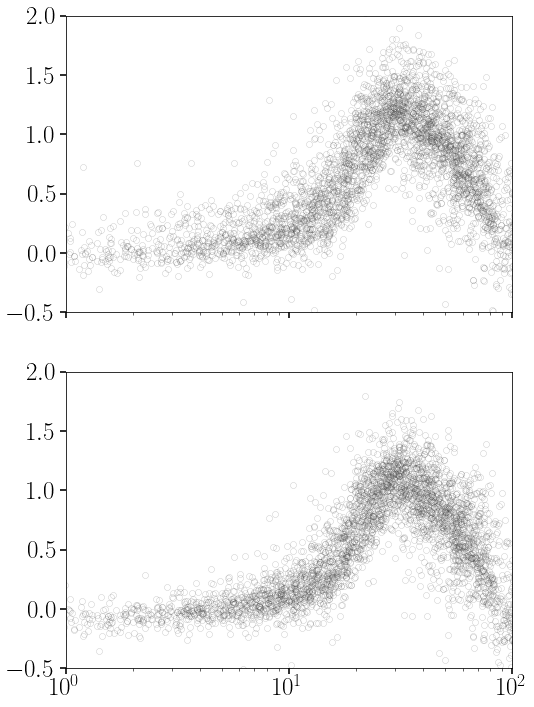

In [29]:
lcs = glob.glob('./early18ia/*dat')
lcs.sort()
fig, ax = plt.subplots(2, 1, figsize=(8, 12), sharex=True, sharey=True)
for lc in lcs:
    name = lc.split('/')[-1].split('.')[0]
    raw = pd.read_csv(lc, sep=' ')
    lc_g = np.array(raw)[:, :-1][raw['fid'] == 1]
    lc_r = np.array(raw)[:, :-1][raw['fid'] == 2]
    g_r = mag1_mag2(lc_g, lc_r)
    ebv = np.array(ebv_sbv['ebv'])[ebv_sbv['sn'] == name][0]
    ax[0].plot(g_r[0],
               g_r[1],
               'o',
               color='None',
               mec='0.2',
               mew=0.4,
               ms=6,
               alpha=0.3)
    ax[1].plot(g_r[0],
               g_r[1] - max(0, ebv),
               'o',
               color='None',
               mec='0.2',
               mew=0.4,
               ms=6,
               alpha=0.3)
    ax[1].set_xscale('log')
    ax[1].set_xlim(1, 1e2)
    ax[1].set_ylim(-0.5, 2)
